In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from pytorch_msssim import ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim_metric
from tqdm import tqdm


In [2]:
class UIEBDataset(Dataset):
    def __init__(self, raw_dir, clean_dir, transform=None):
        self.raw_images = sorted(os.listdir(raw_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.raw_dir = raw_dir
        self.clean_dir = clean_dir
        self.transform = transform

    def __len__(self):
        return len(self.raw_images)

    def __getitem__(self, idx):
        raw = Image.open(os.path.join(self.raw_dir, self.raw_images[idx])).convert("RGB")
        clean = Image.open(os.path.join(self.clean_dir, self.clean_images[idx])).convert("RGB")

        if self.transform:
            raw = self.transform(raw)
            clean = self.transform(clean)

        return raw, clean

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = UIEBDataset("./UIEB/raw/", "./UIEB/clean/", transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [3]:
class ResUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return torch.relu(self.conv(x) + self.shortcut(x))


class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResUNet, self).__init__()

        self.encoder1 = ResUNetBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ResUNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ResUNetBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ResUNetBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ResUNetBlock(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = ResUNetBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = ResUNetBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = ResUNetBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = ResUNetBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.decoder4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.decoder3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.decoder2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), e1], dim=1))

        return self.activation(self.final_conv(d1))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet().to(device)

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x = x * 255
        y = y * 255
        return self.criterion(self.vgg(x), self.vgg(y))

vgg_loss = VGGPerceptualLoss().to(device)

def total_loss(pred, target, alpha=0.7, beta=0.2, gamma=0.1):
    mse = F.mse_loss(pred, target)
    ssim_l = 1 - ssim(pred, target, data_range=1.0, size_average=True)
    perceptual = vgg_loss(pred, target)
    return alpha * mse + beta * ssim_l + gamma * perceptual

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


C:\Users\music\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\music\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\music/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [07:53<00:00, 1.17MB/s]


In [5]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for noisy, clean in tqdm(dataloader):
        noisy, clean = noisy.to(device), clean.to(device)

        output = model(noisy)
        loss = total_loss(output, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:26<00:00,  1.29it/s]


Epoch [1/50], Loss: 1.5594


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:42<00:00,  1.09it/s]


Epoch [2/50], Loss: 1.1579


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:50<00:00,  1.01it/s]


Epoch [3/50], Loss: 1.0770


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:52<00:00,  1.01s/it]


Epoch [4/50], Loss: 1.0408


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [01:59<00:00,  1.06s/it]


Epoch [5/50], Loss: 1.0234


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:03<00:00,  1.10s/it]


Epoch [6/50], Loss: 1.0035


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:05<00:00,  1.12s/it]


Epoch [7/50], Loss: 0.9898


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:09<00:00,  1.16s/it]


Epoch [8/50], Loss: 0.9708


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:08<00:00,  1.14s/it]


Epoch [9/50], Loss: 0.9615


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:09<00:00,  1.16s/it]


Epoch [10/50], Loss: 0.9597


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:11<00:00,  1.17s/it]


Epoch [11/50], Loss: 0.9492


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:14<00:00,  1.20s/it]


Epoch [12/50], Loss: 0.9445


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:03<00:00,  1.10s/it]


Epoch [13/50], Loss: 0.9373


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:01<00:00,  1.09s/it]


Epoch [14/50], Loss: 0.9296


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:01<00:00,  1.09s/it]


Epoch [15/50], Loss: 0.9187


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:07<00:00,  1.14s/it]


Epoch [16/50], Loss: 0.9270


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.17s/it]


Epoch [17/50], Loss: 0.9168


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.17s/it]


Epoch [18/50], Loss: 0.9041


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.17s/it]


Epoch [19/50], Loss: 0.8921


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.16s/it]


Epoch [20/50], Loss: 0.8959


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:18<00:00,  1.23s/it]


Epoch [21/50], Loss: 0.8923


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:18<00:00,  1.24s/it]


Epoch [22/50], Loss: 0.8861


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:16<00:00,  1.22s/it]


Epoch [23/50], Loss: 0.8772


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.16s/it]


Epoch [24/50], Loss: 0.8893


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.17s/it]


Epoch [25/50], Loss: 0.8725


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:11<00:00,  1.18s/it]


Epoch [26/50], Loss: 0.8668


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:10<00:00,  1.16s/it]


Epoch [27/50], Loss: 0.8635


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:16<00:00,  1.22s/it]


Epoch [28/50], Loss: 0.8519


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:47<00:00,  1.50s/it]


Epoch [29/50], Loss: 0.8470


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:45<00:00,  1.48s/it]


Epoch [30/50], Loss: 0.8435


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:20<00:00,  1.25s/it]


Epoch [31/50], Loss: 0.8375


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:27<00:00,  1.31s/it]


Epoch [32/50], Loss: 0.8302


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:48<00:00,  1.50s/it]


Epoch [33/50], Loss: 0.8269


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:40<00:00,  1.43s/it]


Epoch [34/50], Loss: 0.8190


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:48<00:00,  1.50s/it]


Epoch [35/50], Loss: 0.8054


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:47<00:00,  1.50s/it]


Epoch [36/50], Loss: 0.8100


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:17<00:00,  1.76s/it]


Epoch [37/50], Loss: 0.8082


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]


Epoch [38/50], Loss: 0.7988


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:30<00:00,  1.35s/it]


Epoch [39/50], Loss: 0.7868


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:55<00:00,  1.56s/it]


Epoch [40/50], Loss: 0.7798


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [03:12<00:00,  1.72s/it]


Epoch [41/50], Loss: 0.7714


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.54s/it]


Epoch [42/50], Loss: 0.7661


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:54<00:00,  1.56s/it]


Epoch [43/50], Loss: 0.7540


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:48<00:00,  1.50s/it]


Epoch [44/50], Loss: 0.7523


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:43<00:00,  1.46s/it]


Epoch [45/50], Loss: 0.7351


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:26<00:00,  1.31s/it]


Epoch [46/50], Loss: 0.7348


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:24<00:00,  1.29s/it]


Epoch [47/50], Loss: 0.7241


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:19<00:00,  1.25s/it]


Epoch [48/50], Loss: 0.7189


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:25<00:00,  1.30s/it]


Epoch [49/50], Loss: 0.7060


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [02:24<00:00,  1.29s/it]

Epoch [50/50], Loss: 0.7048


PSNR: 24.34, SSIM: 0.9624


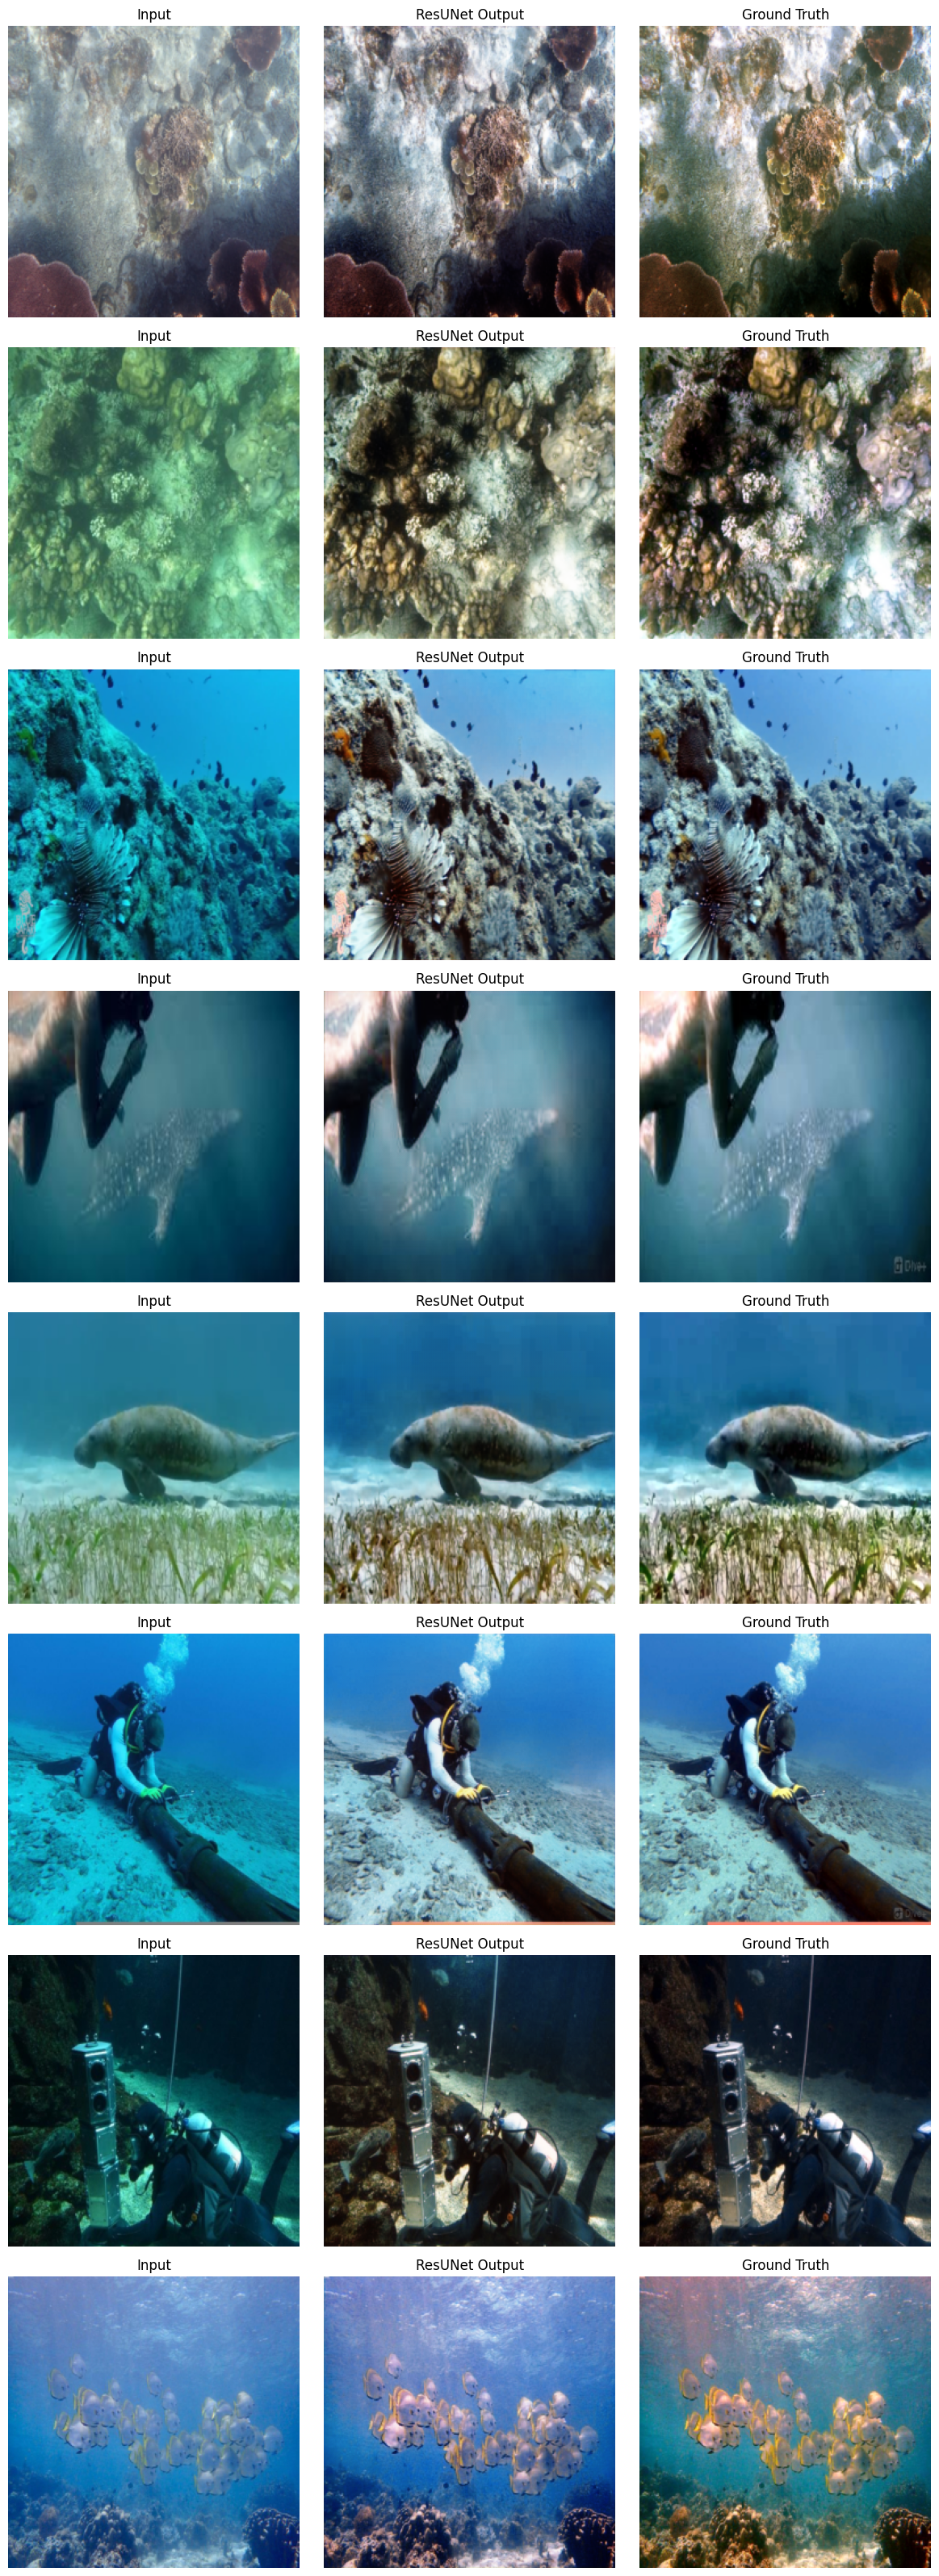

In [13]:
model.eval()
with torch.no_grad():
    noisy, clean = next(iter(dataloader))
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy).cpu()

    # Convert tensors to numpy arrays
    output_np = output.detach().numpy()
    clean_np = clean.cpu().detach().numpy()

    psnr_val = psnr(output_np, clean_np, data_range=1.0)
    ssim_val = ssim_metric(output_np, clean_np, channel_axis=-1, data_range=1.0, win_size=3)

    print(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    # Number of samples to display (max: batch size)
    num_samples = min(10, noisy.shape[0])  # change 4 to show more/less

    # Visualize multiple rows (each row: input, output, ground truth)
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Noisy input
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(noisy[i].cpu().permute(1, 2, 0))
        plt.title("Input")
        plt.axis('off')

        # Model output
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(output[i].permute(1, 2, 0))
        plt.title("ResUNet Output")
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(clean[i].cpu().permute(1, 2, 0))
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
